In [1]:
from pandas import Timestamp
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.tseries.offsets import BDay

In /home/aaron/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/aaron/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/aaron/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


# Base Roller

In [2]:
class BaseFuturesRoller:
    
    def fit(self, dataset: pd.DataFrame):
        """
        Stores price data in the class object for later processing.
        
        :param dataset: (pd.DataFrame) Future price data.
        """
        
        self.dataset = dataset
        
        return self
    
    def diagnostic_summary(self) -> pd.DataFrame:
        """
        After the dataset has been transformed, a dataframe with all the dates
        of each roll operation is stored in the class object. This will return
        that dataframe.
        
        :return: Returns DataFrame with each roll and gap size.
        """
        
        return self.diagnostic_frame
    
    def transform(self, roll_forward: bool = True, handle_negative_roll: bool = False) -> pd.Series:
        """
        Processes the dataset provided with the set roll dates.
        
        :param roll_forward: (bool) The direction which the gaps should sum to.
        :param handle_negative_roll: (bool) Process to remove negative values from series.
        :return: Series of gaps or Preprocessed rolled series.
        """
        
        roll_dates = self._get_rolldates(self.dataset)
        
        gaps_series, diagnostic_frame = self.roll(self.dataset, roll_dates, roll_forward)
        
        self.diagnostic_frame = diagnostic_frame
        
        if handle_negative_roll:
            rolled_series = self.dataset['PX_LAST'] - gaps_series
            return self.non_negativeize(rolled_series, self.dataset['PX_LAST'])
        else:
            return gaps_series
        
    def _get_rolldates(self, dataset: pd.DataFrame) -> bool:
        """
        To be overrided as needed.
        
        :return: False.
        """
        
        return False # Not Implemented.

    def generate_diagnostic_frame(self, dataset: pd.DataFrame, termination_date_indexes: np.array,
                                  following_dates: pd.DateTimeIndex) -> pd.DataFrame:
        """
        Returns dataframe full of every roll operation and its gap size.

        :param dataset: (pd.DataFrame) Price data. Must have columns [PX_OPEN, PX_LAST].
        :param termination_date_indexes: (np.array) Indexes of termination dates.
        :param following_dates: (pd.DateTimeIndex) Dates following the termination dates.
        :return: (pd.DataFrame) List of dates and their gap's size.
        """

        diag_df = pd.DataFrame({})
        diag_df['last_on_termination_date'] = dataset['PX_LAST'].iloc[termination_date_indexes].index
        diag_df['last_prices'] = dataset['PX_LAST'].iloc[termination_date_indexes].values
        diag_df['open_day_after_termination_date'] = following_dates
        diag_df['open_prices'] = dataset['PX_OPEN'].loc[following_dates].values

        diag_df['gap'] = dataset['PX_OPEN'].loc[following_dates].values
                                - dataset['PX_LAST'].iloc[termination_date_indexes].values

        return diag_df


    def get_x_days_prior_available_target_date(self, n_days: int, dataset_datetime_index: pd.DateTimeIndex,
                                               target_dates: pd.DateTimeIndex) -> pd.DataFrame:
        """
        Gets x days prior to target date(that must be available in the dataset index).

        :param n_days: (int) Number of days to be shifted by
        :param dataset_datetime_index: (pd.DateTimeIndex) All dates that occur in the dataset
        :param target_dates: (pd.DateTimeIndex) Dates used as the start for the shift. Important
            these dates need to exist in 'dataset_datetime_index'.
        :return: (pd.Series) 
        """

        price_series = pd.DataFrame()
        indexed_list = list(dataset_datetime_index)
        indexed_list = [indexed_list.index(i)-n_days for i in target_dates.dropna()]
        price_series['expiry'] = dataset_datetime_index.iloc[indexed_list]
        
        return price_series

    def get_available_date_per_month_from(self, price_df: pd.DataFrame, mode: str,
                                          nth_day: int = 0) -> pd.DataFrame:
        """

        :param price_df: (pd.DataFrame)
        :param mode: (str) Available modes; ["first", "last", "specific"]
        :param nth_day: (int)
        :return: (pd.DataFrame)
        """

        price_series = pd.DataFrame()
        price_series['dates'] = price_df.index
        price_series['expiry_month'] = price_df.index.to_period('M')  
        price_series['day'] = price_df.index.to_period('D').day

        if mode == "first":
            price_series['target_day'] = price_series.groupby(by=['expiry_month'])['day'].transform(min)
        elif mode == "last":
            price_series['target_day'] = price_series.groupby(by=['expiry_month'])['day'].transform(max)
        elif mode == "specifc":
            price_series['target_day'] = price_series.groupby(by=['expiry_month'])['day'].nth(nth_day)
        else:
            print("Please select a valid mode!")

        price_series['target_date'] = price_series['expiry_month'].astype(str) 
                                            + "-" + price_series['target_day'].astype(str)

        price_series['target_date'] = pd.to_datetime(price_series['target_date'], errors='coerce')
        
        return price_series

    def get_all_possible_static_dates_in(self, dataset_datetime_index: pd.DateTimeIndex,
                                         day_of_month: int = 25) -> pd.DataFrame:
        """
        Gets a series of static dates that could happen in a specific time range, described
        by the input 'dataset_datetime_index'. The dates returned from this method do not take 
        into consideration the fact of if the specified date happened in the dataset or not.

        :param dataset_datetime_index: (pd.DateTimeIndex) All dates that occur in the dataset
        :param day_of_month: (int) Day of month    
        :return: (pd.DataFrame) Dates
        """

        price_series = pd.DataFrame()
        price_series['original_index'] = dataset_datetime_index
        price_series['expiry_month'] = dataset_datetime_index.to_period('M')
        price_series['day'] = day_of_month
        price_series['target_date'] = price_series['expiry_month'].astype(str)
                                            + "-" + price_series['day'].astype(str)

        price_series['target_date'] = pd.to_datetime(price_series['target_date'], errors='coerce')
        
        return price_series[['original_index', 'target_date']]

    def get_x_days_prior_missing_target_date(self, dataset: pd.DataFrame,
                                             working_month_delta: pd.Period, days_prior: int = 3,
                                             target_day: int = 25) -> str:
        """
        This method will get x available day prior to a specific date, in the special case that that
        date doesn't exist in the dataset.

        :param dataset: (pd.DataFrame)
        :param working_month_delta: (pd.Period) specific Year-Month delta, ex. 1995-12
        :param days_prior: (int)
        :param target_day: (int)
        :return: (Date)
        """

        # Use delta to get all days in that month from the original series.
        full_working_month = dataset.loc[pd.to_datetime(dataset.index).to_period('M') == working_month_delta]

        # Remove all days including and after target_date
        full_working_month = full_working_month[full_working_month.index.day < target_day]

        # Get Bottom x days and select the first one of them
        return full_working_month.last(str(days_prior) + 'd').first('d').index.values

    def roll(self, dataset: pd.DataFrame, roll_dates: pd.Series, match_end: bool = True):
        """
        
        :param dataset: (pd.DataFrame)
        :param roll_dates: (pd.Series)
        :param match_end: (bool)
        :return: (pd.Series) (pd.DataFrame)
        """
        gaps = dataset['PX_LAST']*0

        iloc=list(dataset.index)

        iloc = [iloc.index(i)-1 for i in roll_dates]

        gaps.loc[roll_dates] = dataset['PX_OPEN'].loc[roll_dates] - dataset['PX_LAST'].iloc[iloc].values

        gaps = gaps.cumsum().dropna()

        if match_end:
            gaps -= gaps.iloc[-1]

        return gaps, self.generate_diagnostic_frame(dataset, iloc, roll_dates)

    def non_negativeize(self, rolled_series: pd.Series, raw_series: pd.Series) -> pd.Series:
        """
        
        :param rolled_series: (pd.Series)
        :param raw_series: (pd.Series)
        :return: (pd.Series)        
        """
        new_prices_series = rolled_series.copy()
        new_prices_series = rolled_series.diff() / raw_series.shift(1)
        new_prices_series = (1+new_prices_series).cumprod()
        
        return new_prices_series

# CRUDE WTI

In [20]:
cl_df = pd.read_csv('./data/CL.csv')
cl_df['Dates'] = pd.to_datetime(cl_df['Dates'])
cl_df.dropna(inplace=True)
cl_df.index = cl_df['Dates']
cl_df = cl_df['2006-01': '2019-12']

In [1]:
class CrudeOilFutureRoller(BaseFuturesRoller):
    """
    Rolls the contract data provided under the assumption 
    trading terminates 3 business day prior to the 25th calendar day
    of the month prior to the contract month. If the 25th calendar 
    day is not a business day, trading terminates 4 business days prior to
    the 25th calendar day of the month prior to the contract month.
    
    *NOTE*
    If you have reasons to believe that the termination dates / expiration
    method changed throughout the time series, direct your attention to:
    
    https://www.cmegroup.com/tools-information/advisory-archive.html
    
    may god have mercy on your soul.
    """
    
    def _get_rolldates(self, dataset: pd.DataFrame) -> pd.Series:
        """
        
        :param dataset: (pd.DataFrame)
        :return: (pd.Series)
        """
        
        # Get all monthly 25ths in the date range specified in the dataset 
        cl_final_df = super().get_all_possible_static_dates_in(dataset.index, 25)

        # Remove duplicate dates from the list
        twnty_fives = cl_final_df['target_date'].drop_duplicates()

        working_frame = pd.DataFrame(twnty_fives)
        working_frame['is_in_original_index'] = pd.Series(twnty_fives.isin(cl_final_df['original_index']))

        # Diagnostic check; How many 25ths actually occur in the dataset?
        # working_frame['is_in_original_index'].value_counts()
        # (True: 230, False: 92, Name: is_in_original_index, dtype: int64)

        # CRITICAL ASSUMPTION HERE :
        # ALL HOLIDAYS SHOULD HAVE NO PRICING DATA BECAUSE IT'S A HOLIDAY 

        futures_df_index = list(dataset.index)

        # Get all 25ths that have occured (ie. have price data), and get 2 days prior to them.
        roll_over_dates_for_business_days = [futures_df_index.index(i)-2 for i in working_frame
                                        [working_frame['is_in_original_index'] == True]['target_date'].values]

        # DIAGNOSIS PRINT:
        # futures_prices_df.iloc[roll_over_dates_for_business_days].index.values

        # Get all 25ths that did not occur (ie. they were holidays so no price data for that day).
        roll_over_dates_on_holidays = working_frame[working_frame['is_in_original_index'] == False]['target_date']

        roll_over_dates_for_holidays = []

        # Get x business days prior to (non business day) 25th that are available in the dataset. 
        for date in roll_over_dates_on_holidays:
            roll_over_dates_for_holidays.append( 
                super().get_x_days_prior_missing_target_date(dataset, date.to_period('M'), 3) )

        roll_over_dates_for_holidays = np.ravel(roll_over_dates_for_holidays)

        # DIAGNOSIS PRINT:
        # roll_over_dates_for_holidays    

        all_roll_overs =pd.concat([ pd.Series(roll_over_dates_for_holidays),
                              pd.Series(dataset.iloc[roll_over_dates_for_business_days].index.values) ])

        # DIAGNOSIS PRINT:
        # is_expiry_busines_day(pd.DataFrame(all_roll_overs, 
        #            columns=['roll_over_dates']), 'roll_over_dates')['is_in_original_index'].value_counts()

        return all_roll_overs.sort_values().values


NameError: name 'BaseFuturesRoller' is not defined

In [21]:
wti_roller = CrudeOilFutureRoller().fit(cl_df)
wti_gaps = wti_roller.transform()

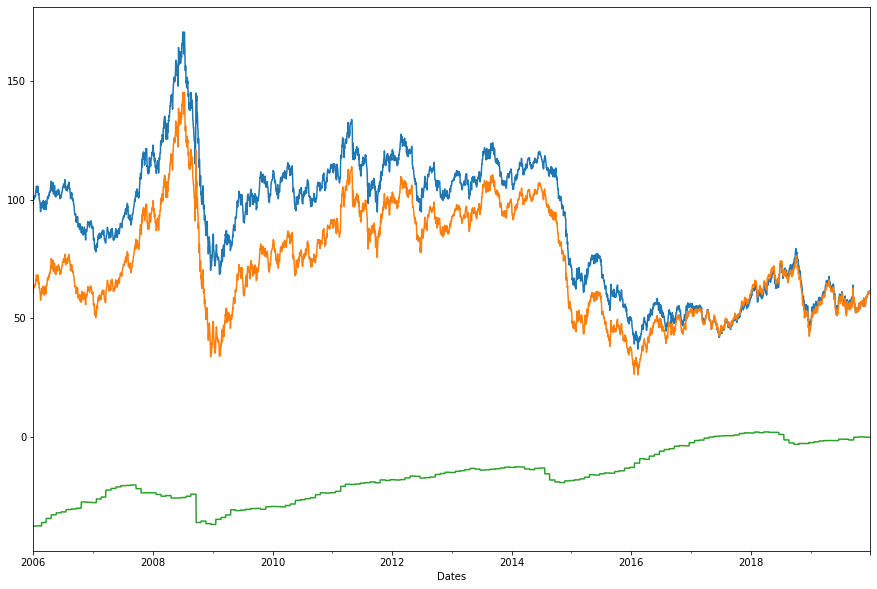

In [22]:
(cl_df['PX_LAST'] - wti_gaps).plot(figsize=(15,10))
cl_df['PX_LAST'].plot()
wti_gaps.plot()

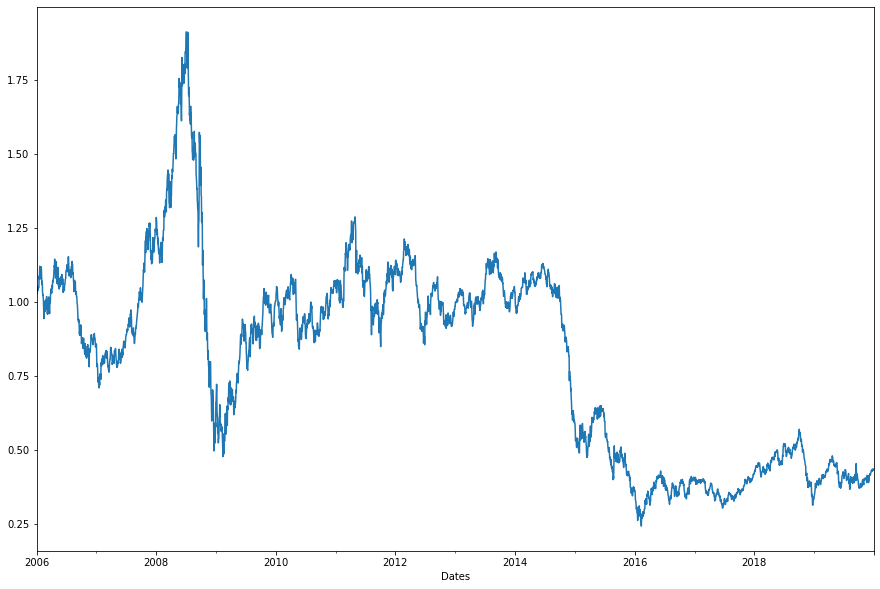

In [23]:
non_negative_cl = wti_roller.transform(handle_negative_roll=True) 
non_negative_cl.to_csv('./NonNegative_CL_forward_roll.csv')
non_negative_cl.plot(figsize=(15,10))

In [8]:
wti_diag_frame = wti_roller.diagnostic_summary()
wti_diag_frame.head(10)

,last_on_termination_date,last_prices,open_day_after_termination_date,open_prices,gap
0,1994-01-20,15.10,1994-01-21,15.27,0.17
1,1994-02-22,14.24,1994-02-23,14.30,0.06
2,1994-03-22,15.20,1994-03-23,15.35,0.15
3,1994-04-20,16.82,1994-04-21,16.46,-0.36
4,1994-05-20,18.92,1994-05-23,18.50,-0.42
5,1994-06-21,20.04,1994-06-22,20.65,0.61
6,1994-07-20,19.20,1994-07-21,19.42,0.22
7,1994-08-22,16.87,1994-08-23,17.58,0.71
8,1994-09-20,17.24,1994-09-21,17.31,0.07
9,1994-10-20,17.54,1994-10-21,17.41,-0.13


In [9]:
wti_diag_frame.sort_values('gap').head(10)

,last_on_termination_date,last_prices,open_day_after_termination_date,open_prices,gap
176,2008-09-22,120.92,2008-09-23,108.98,-11.94
247,2014-08-20,96.07,2014-08-21,93.49,-2.58
77,2000-06-20,33.05,2000-06-21,30.52,-2.53
84,2001-01-22,32.19,2001-01-23,29.69,-2.50
246,2014-07-22,104.42,2014-07-23,101.96,-2.46
294,2018-07-20,70.46,2018-07-23,68.17,-2.29
26,1996-03-20,23.06,1996-03-21,20.90,-2.16
28,1996-05-21,22.65,1996-05-22,20.50,-2.15
111,2003-04-22,29.91,2003-04-23,27.90,-2.01
109,2003-02-20,36.79,2003-02-21,34.80,-1.99


# NBP UK Gas

Trading will cease at the close of business two Business Days prior to the first calendar day of the delivery month, quarter, season, or calendar.

In [10]:
nbp_df = pd.read_csv('./data/NBP.csv')
nbp_df['Dates'] = pd.to_datetime(nbp_df['Dates'])
nbp_df.set_index('Dates', inplace=True)

In [11]:
class NBPFutureRoller(BaseFuturesRoller):
    # Rolls the contract data provided under the assumption that
    # the termination date is the penultimate business day of the month.
    
    def _get_rolldates(self, dataset: pd.DataFrame) -> pd.Series:
        """
        
        :param dataset: (pd.DataFrame)
        :return: (pd.Series)
        """

        target_dates = super().get_available_date_per_month_from(dataset, 'first')
        
        final_df = super().get_x_days_prior_available_target_date(1, 
                                                  dataset.index.to_series(), target_dates['target_date'])

        nbp_roll_dates = final_df['expiry'].drop_duplicates().dropna().values[:-1]

        return nbp_roll_dates


In [12]:
nbp_roller = NBPFutureRoller().fit(nbp_df)
nbp_gaps = nbp_roller.transform()

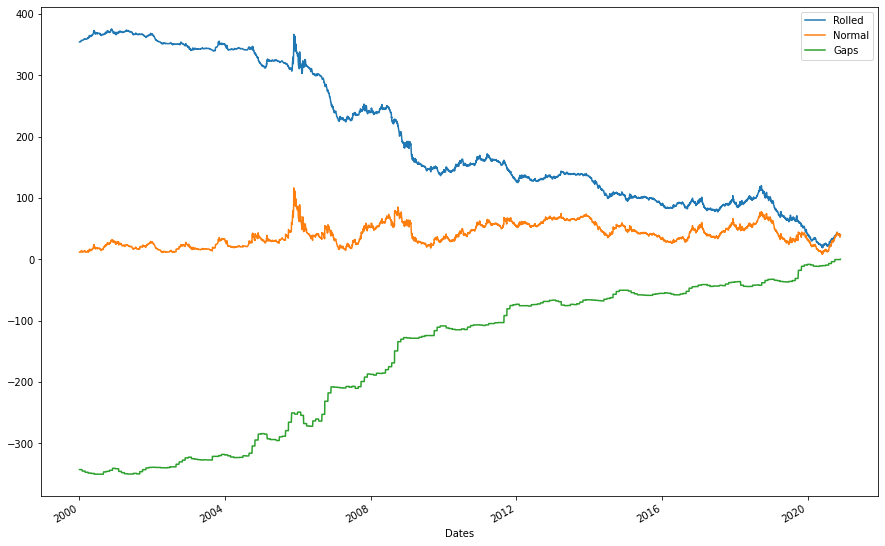

In [13]:

(nbp_df['PX_LAST'] - nbp_gaps).plot(figsize=(15,10))
nbp_df['PX_LAST'].plot()
nbp_gaps.plot()

plt.legend(["Rolled", "Normal", "Gaps"])

In [14]:
nbp_diag_frame = nbp_roller.diagnostic_summary()
nbp_diag_frame.head(10)

,last_on_termination_date,last_prices,open_day_after_termination_date,open_prices,gap
0,2020-11-24,39.04,2020-11-25,39.48,0.44
1,2000-01-28,13.98,2000-01-31,11.55,-2.43
2,2000-02-28,13.90,2000-02-29,12.00,-1.90
3,2000-03-30,13.10,2000-03-31,11.75,-1.35
4,2000-04-27,14.83,2000-04-28,14.20,-0.63
5,2000-05-30,23.78,2000-05-31,22.60,-1.18
6,2000-06-29,18.18,2000-06-30,18.15,-0.03
7,2000-07-28,16.85,2000-07-31,16.90,0.05
8,2000-08-30,16.01,2000-08-31,19.65,3.64
9,2000-09-28,23.00,2000-09-29,23.95,0.95


# RBOB

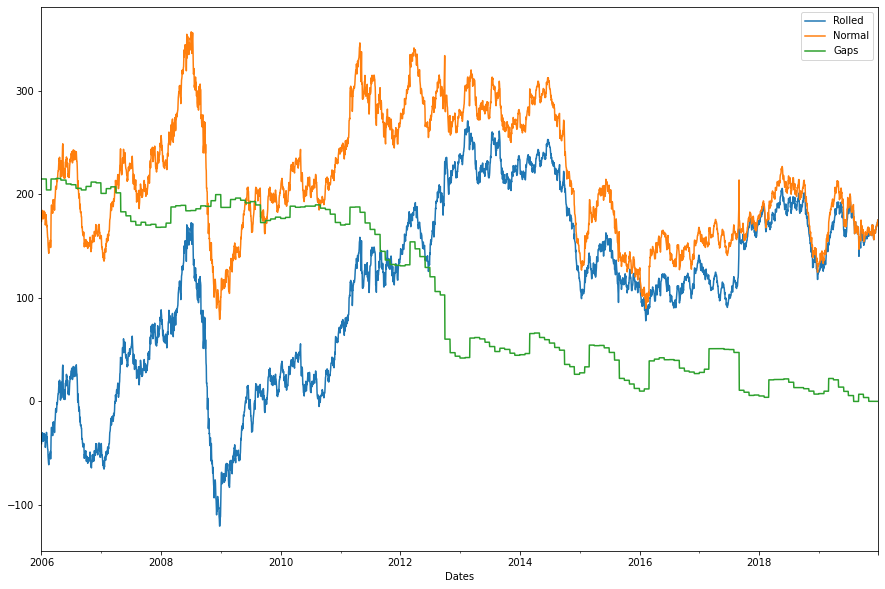

In [24]:
rb_df = pd.read_csv('./data/RB.csv').dropna()
rb_df['Dates'] = pd.to_datetime(rb_df['Dates'])
rb_df.set_index('Dates', inplace=True)
rb_df = rb_df['2006-01': '2019-12']

class RBFutureRoller(BaseFuturesRoller):
    # Rolls the contract data provided under the assumption that
    # the termination date is the last business day of the month.
    
    # The following contracts can be used under this class.
    
    # Refined Products
    # - FO - Trading terminates on the last London business day of the contract month.
    # - 7K - Trading terminates on the last business day of the contract month.
    # - ME - Trading shall cease on the last business day of the contract month.
    # - 1L - Trading terminates on the last business day of the contract month.
    # - LT - Trading shall cease on the last business day of the contract month.
    # - HO - Trading terminates on the last business day of the month prior to the contract month.
    # - M1B - Trading terminates on the last business day of the contract month.
    # - M35 - Trading terminates on the last business day of the contract month.
    # - NYA - Trading terminates on the last business day of the contract month
    # - NYR - Trading terminates on the last business day of the contract month
    # - RBOB - Trading terminates on the last business day of the month prior to the contract month.

    # Crude Oil
    # - LLB - Trading terminates on the last business day of the contract month.
    # - LWB - Trading terminates on the last business day of the contract month.
    # - WJ - Trading terminates on the last business day of the contract month.
    # - CS - Trading shall cease on the last business day of the contract month.
    # - BK - Trading shall cease on the last business day of the contract month.

    # BioFules
    # - CU - Trading terminates on the last business day of the contract month. 
    
    
    def _get_rolldates(self, dataset: pd.DataFrame) -> pd.Series:
        """
        
        :param dataset: (pd.DataFrame)
        :return: (pd.Series)
        """
        
        target_dates = super().get_available_date_per_month_from(dataset, 'first')
        
        rb_roll_dates = target_dates['target_date'].drop_duplicates().dropna().values[1:]

        return rb_roll_dates

    
rbob_roller = RBFutureRoller().fit(rb_df)
rbob_gaps = rbob_roller.transform()

(rb_df['PX_LAST'] - rbob_gaps).plot(figsize=(15,10))
rb_df['PX_LAST'].plot()
rbob_gaps.plot()

plt.legend(["Rolled", "Normal", "Gaps"])

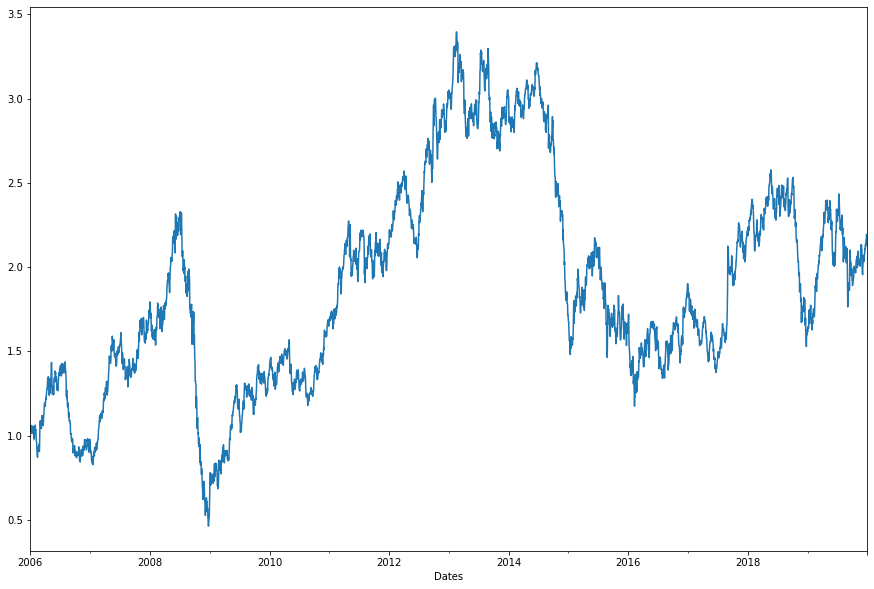

In [25]:
non_negative_rbob = rbob_roller.transform(handle_negative_roll=True)
non_negative_rbob.to_csv('./NonNegative_RB_forward_roll.csv')
non_negative_rbob.plot(figsize=(15,10))

In [17]:
rb_diag_frame = rbob_roller.diagnostic_summary()
rb_diag_frame.head(10)

,last_on_termination_date,last_prices,open_day_after_termination_date,open_prices,gap
0,2005-12-30,174.00,2006-01-02,165.00,-9.00
1,2006-01-31,175.58,2006-02-01,165.00,-10.58
2,2006-02-28,154.43,2006-03-01,165.00,10.57
3,2006-03-31,206.45,2006-04-03,207.00,0.55
4,2006-04-28,221.00,2006-05-01,219.40,-1.60
5,2006-05-31,228.73,2006-06-01,225.00,-3.73
6,2006-06-30,239.31,2006-07-03,238.55,-0.76
7,2006-07-31,234.96,2006-08-01,231.50,-3.46
8,2006-08-31,182.07,2006-09-01,180.50,-1.57
9,2006-09-29,156.32,2006-10-02,159.70,3.38


# DEPRADO'S IMPLEMENTATION - FOR REFERENCE

In [17]:
# def getRolledSeries(pathIn, key):
#     series=//
#     series['Time'] = pd.to_datetime(series['Time'], format='%%%%')
#     series=series.set_index('Time')
#     gaps=rollGaps(series)
#     for fld in ['Close', 'VWAP']: 
#         series[fld] -= gaps
#     return series

# def rollGaps(series, dictio={'Instrument':'FUT_CUR_GEN_TICKER', 'Open':'PX_OPEN', 'Close':'PX_LAST'}, matchEnd=True):
#     rollDates= series[dictio['Instrument']].drop_duplicates(keep='first').index
#     gaps=series[dictio['Close']]*0
#     iloc=list(series.index)
#     iloc=[iloc.index(i)-1 for i in rollDates]
#     gaps.loc[rollDates[1:]]=series[dictio['Open']].loc[rollDates[1:]] - series[dictio['Close']].iloc[iloc[1:]].values
#     gaps=gaps.cumsum()
#     if matchEnd:
#         gaps -= gaps.iloc[-1]
#     return gaps